<a href="https://colab.research.google.com/github/ahmedtarek-/Deep-Q-Learning/blob/main/deep_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
  <img style="float: left;"  width="140" src=" 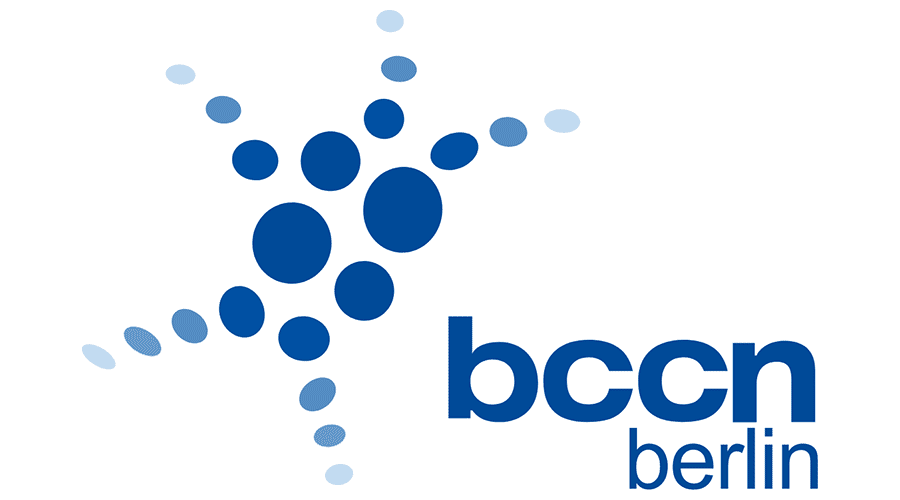">
</div>

<h1 id="course-title-heading">
    <div style="text-align: right">
        Models of Higher Brain Functions
        <br>Computer Course
        <br>
    </div>
</h1>
    
---
<div style="text-align: left; float: left">
    Lecturer: Prof. Dr. Henning Sprekeler
</div>

<div style="text-align: right">
    Assistant: Jarek Liesen
    <br>(jarek@bccn-berlin.de)
</div>



# Deep Q-Learning Project (MHBF)

Names: Ahmed Abdalfatah - Arina Belova
Group: "O"

In [1]:
# Cloning the required files from git directly to avoid pain
!git clone https://github.com/ahmedtarek-/Deep-Q-Learning.git
!cp -r /content/Deep-Q-Learning/gym-grid/gym_grid gym_grid

Cloning into 'Deep-Q-Learning'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 47 (delta 19), reused 31 (delta 11), pack-reused 0
Unpacking objects: 100% (47/47), 42.19 KiB | 1.76 MiB/s, done.


In [2]:
# Install required packages
!pip install -q gym==0.15.4
!pip install -q pycolab==1.2
!pip install -q torch==1.2.0
#!pip install -q matplotlib==3.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.12.1 requires cloudpickle>=1.5.0, but you have cloudpickle 1.2.2 which is incompatible.
tensorflow-probability 0.20.1 requires cloudpickle>=1.3, but you have cloudpickle 1.2.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.7/165.7 kB 3.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==1.2.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.2.0


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import required packages
import random
from collections import OrderedDict

import gym
import gym_grid

import numpy as np
import matplotlib.pyplot as plt

# Part 1 - Environment Implementation

/usr/local/lib/python3.10/dist-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


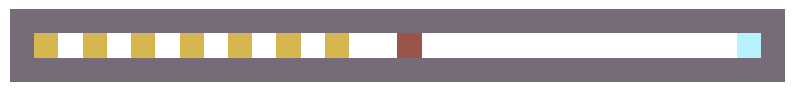

In [ ]:
# Visualize the environment
plt.figure(figsize=(10, 10))

# T-Maze Environment
env = gym.make("LinearTrack-v0")
_, obs_to_render = env.reset_with_render()
env.render(obs_to_render)

# TODO: Deadly Gridworld
# env = gym.make("DeadlyGrid-v0")
# _, obs_to_render = env.reset_with_render()
# env.render(obs_to_render)

100
2


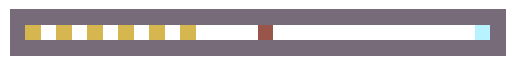

In [ ]:
# Run random steps & Visualize the episode
from IPython import display

_, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
rew_total = 0
for i in range(50):
    action = env.action_space.sample()
    _, rew , done, _, obs_to_render = env.step_with_render(action)
    env.render(obs_to_render)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    rew_total += rew
    if done:
        break
print(rew_total)
print(action)

# Part 2 - Deep Q-Learning Agents

In [ ]:
# PLAYGROUND CELL
states = env.observation_space.shape
actions = env.action_space.n

env.observation_space.shape

(3, 32, 4)

## 2.1) Defining Network

In [ ]:
import torch
import torch.nn as nn

np.random.seed(42)
bs = 128

# Simple MLP class

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, dim_input, dim_output):
    super().__init__()

    self.layers = nn.Sequential(OrderedDict([
    ('hidden', nn.Linear(dim_input, 128)),
    ('act', nn.ReLU()),
    ('output', nn.Linear(128, dim_output)),
    # maybe we want this as well ('outact', nn.Sigmoid()),
    ]))

    # init weights, maybe Xavier init?
    self.layers.apply(self.init_weights)

  def init_weights(self, module):
    if isinstance(module, nn.Linear):
      torch.nn.init.xavier_uniform_(module.weight)
      module.bias.data.fill_(0.01)

  def forward(self, x):
      return self.layers(x)

states = np.prod(env.observation_space.shape)
actions = env.action_space.n

model = MLP(states, actions)
model

MLP(
  (layers): Sequential(
    (hidden): Linear(in_features=384, out_features=128, bias=True)
    (act): ReLU()
    (output): Linear(in_features=128, out_features=3, bias=True)
  )
)

## 2.2) Defining policy

In [ ]:
def eps_greedy(q, e=0.2):
  rand = np.random.uniform(0, 1)
  if rand <= (1 - e):
    chosen_action = torch.argmax(q).item()
  else:
    chosen_action = np.random.choice(range(len(q)))

  q_value = q[chosen_action]
  return chosen_action, q_value

## 2.3) Defining Y_hat

In [ ]:
def calculate_y_hat(reward, max_next_q, eta=0.1):
  return torch.Tensor([reward + eta * max_next_q])

In [ ]:
def rollout_episode(current_state, env, model, policy, discount_factor, episodes_num = 10):
    model.eval()
    rew_total = 0
    discounted_reward_total = 0

    print("Inside rollout")
    for _ in range(episodes_num):
        # use the epsilon greedy policy with a ver small epsilon = 0.01
        q = model(current_state)
        action = policy(q, e = 0.01)
        new_state, rew , done, _ = env.step(action)
        rew_total += rew
        discounted_reward_total += (discount_factor * rew)
        current_state = torch.Tensor(new_state.flatten())

        if done:
          print("is done inside rollout")
          break

    model.train()
    return rew_total, discounted_reward_total, done

## 2.4) Defining main loop

In [ ]:

def the_loop(model, env, loss_function, num_update_steps = 20000, num_episodes = 50, policy = eps_greedy, evaluate_steps = 500, discount_factor = 0.1):
  # episodes num = 50/100 and updates = 20000/100000
  #for update_step in range(num_update_steps):
  counter = 0
  while counter < num_update_steps:
    #print(update_step)
    current_state = env.reset()

    for _ in range(num_episodes):
      # TODO: another for loop for batches

      # 1. Forward pass on NN to get the Q(t)
      #print(current_state.shape)
      current_state_tensor = torch.Tensor(current_state.flatten())
      q_t = model(current_state_tensor)

      # 2. Decide which action to choose based on annealing epsilon greedy policy
      # TODO: # sigmoid schedule on the epsilon so we have more exploration
      chosen_action, current_q_value = policy(q_t, e = 1 * (1 - ((counter + 1) / num_update_steps)))
      #print(f"Current q value is {current_q_value}")

      # 3. Take action/step and get reward and next state
      next_state, reward , done, _ = env.step(chosen_action)

      # 3(a). Store in experence replay buffer:
      #store_in_experience_replay(current_state_tensor, chosen_action, reward, next_state, done)

      # 4. Run another forward pass to get all q_values for next_state
      next_state_tensor = torch.Tensor(next_state.flatten())

      # TODO: forgot to update current state, so it was learning a lot from the initial state:
      current_state_tensor = next_state_tensor

      q_next_t = model(next_state_tensor)

      # 5. Get maximum q_value, greedy action
      _, next_max_q_value = policy(q_next_t, e=0)
      #next_max_q_value, q_next_t

      # 6. Calculate Y_hat
      y_hat = calculate_y_hat(reward, next_max_q_value, done * 1).detach()
      #print(f"Do we require grad? {y_hat.requires_grad}")

      # 7. Loss function
      loss = loss_function(current_q_value, y_hat)
      #print(current_q_value.type())
      #print(y_hat.type())

      # 8. Backpropagate to learn
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 9. Check if we terminate an episode due to one of the termination conditions
      if done:
        break

      # 10. TODO: Do the evaluation every 500 steps
      # run in the env under greedy policy to get running reward
      if (counter % evaluate_steps) == 0:
        with torch.no_grad():
          rew_intermediate, disc_rew_intermediate, rollout_done = rollout_episode(current_state_tensor, env, model, policy, discount_factor)
          print(f"Intermediate reward after {counter} update is {rew_intermediate}")
          print(f"Intermediate discounted reward after {counter} update is {disc_rew_intermediate}")
        if rollout_done:
          break

      # step counter
      counter +=1

      # 11. Check if we're out of updating for good.
      if counter >= num_update_steps:
        break

      # YAAAY repeat now


## 2.5) Defining the experience replay data structures

In [63]:
class ExperienceBatch():
  def __init__(self, current_states, actions, rewards, next_states):
    self.current_states = current_states
    self.actions = actions
    self.rewards = rewards
    self.next_states = next_states

  def current_states(self):
    return self.current_states

  def actions(self):
    return self.actions

  def rewards(self):
    return self.rewards

  def next_states(self):
    return self.next_states

  def size(self):
    return self.actions.shape[0]

  def items(self):
    """
    ACHTUNG: not so effecient; more for testing than using in training
    """
    return list(zip(self.current_states, self.actions, self.rewards, self.next_states))


class ExperienceBuffer():
  DEFAULT_BATCH_SIZE = 128

  def __init__(self, shape, capacity=1000):
    """
      Parameters:
        - shape: Describes the size of each component.
          Example:
            - A 'state' is represented by 420 numbers
            - Reward is a scalar value
            - Action is a scalar value
            - Then the shape will be (420, 1, 1, 420)
        - capacity: Defines the total capacity of the buffer
    """
    self.capacity = capacity
    self.current_index = 0
    self.current_states = np.zeros((capacity, shape[0]))
    self.actions = np.zeros((capacity, shape[1]))
    self.rewards = np.zeros((capacity, shape[2]))
    self.next_states = np.zeros((capacity, shape[3]))

  def add(self, current_state, action, reward, next_state):
    self.current_states[self.current_index] = current_state
    self.actions[self.current_index] = action
    self.rewards[self.current_index] = reward
    self.next_states[self.current_index] = next_state

    self.update_index()

  def update_index(self):
    """
    Updates the index that is being used to populate the buffer;
    the 'current_index' is set to 0 whenever we reach the end of the buffer
    to override the very first values that were added (FIFO).
    """
    if self.current_index == (self.capacity - 1):
      self.current_index = 0
    else:
      self.current_index += 1

  def get_next(self, batch_size=DEFAULT_BATCH_SIZE):
    """
    If the buffer hasn't reached the 'buffer_size' yet, then we return a batch
    representing all the data in the buffer. Otherwise we sample 'buffer_size'
    items from the buffer.
    """
    if self.size() <= batch_size:
      indices = np.arange(0, self.size())
    else:
      indices = np.random.randint(self.size(), size=batch_size)
    return ExperienceBatch(*self.items(indices))

  def size(self):
    return np.count_nonzero(self.actions)

  def items(self, indices=None):
    return (self.current_states[indices],
      self.actions[indices],
      self.rewards[indices],
      self.next_states[indices]
    )

  def __str__(self):
    return f"""
      Capacity: {self.capacity}
      Size: {self.size()}
      Current Index: {self.current_index}
      Shape: ({self.current_states.shape[1]},{self.actions.shape[1]},{self.rewards.shape[1]},{self.next_states.shape[1]})
    """

In [66]:
# Example on how to use this mofo?

# A) Initialize with shape tuple (assuming state is represented by 4 values)
exp_buffer = ExperienceBuffer((4,1,1,4))

# B) Ad some items to the buffer (5 items)
exp_buffer.add(np.array([1,2,3,4]), 1, 2, np.array([1,2,3,90]))
exp_buffer.add(np.array([10,20,30,40]), 1, 0, np.array([1,2,3,90]))
exp_buffer.add(np.array([1000,20,30,4000]), 1, 0, np.array([12,22,32,290]))
exp_buffer.add(np.array([1,2,3,4]), 3, 2, np.array([0,0,0,0]))
exp_buffer.add(np.array([1,1,1,1]), 3, 1, np.array([1,2,3,90]))

# C) Get a batch using a batch_size bigger than number of items (all items)
exp_batch = exp_buffer.get_next()
print(exp_batch.rewards)

# D) Get a batch using a batch_size smaller than number of items (random sample)
exp_batch = exp_buffer.get_next(batch_size=2)
print(exp_batch.rewards)

[[2.]
 [0.]
 [0.]
 [2.]
 [1.]]
[[1.]
 [2.]]


# Part 3 - Testing with environments

## 3.1) Linear track environment

In [ ]:
env = gym.make("LinearTrack-v0")

states = np.prod(env.observation_space.shape)
actions = env.action_space.n

lr = 0.001
model = MLP(states, actions)

# Defining the loss function
loss_func = nn.MSELoss()

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

the_loop(model, env, loss_func)